### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [121]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py
%run lending_dataprep.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

The data objects are now saved and given a set of generic names ease of use.

In [15]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()


In [17]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.9462
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1800}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.8260
Confusion matrix, without normalization
[[488   3   6]
 [  4  49   4]
 [ 21   1  62]]
Normalized confusion matrix
[[0.98 0.01 0.01]
 [0.07 0.86 0.07]
 [0.25 0.01 0.74]]


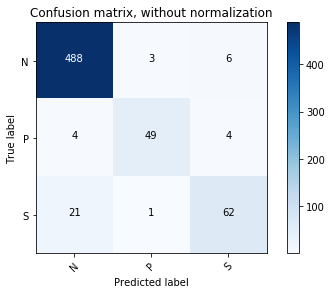

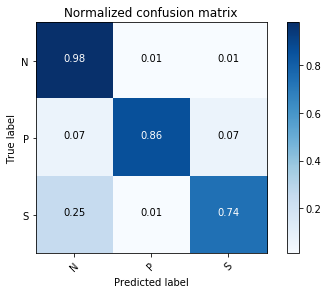

In [18]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [20]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [21]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

if True:
    
    batch = X_test
    labels = y_test

    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()
    
    
tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(num/denom)
C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:204: RuntimeWarning: invalid value encountered in true_divide
  yerr = 0.434*np.sqrt((num_err/num)**2 + (denom_err/denom)**2)


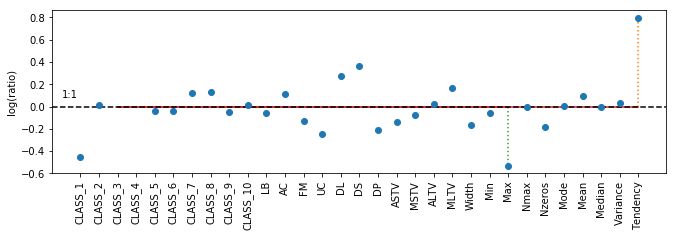

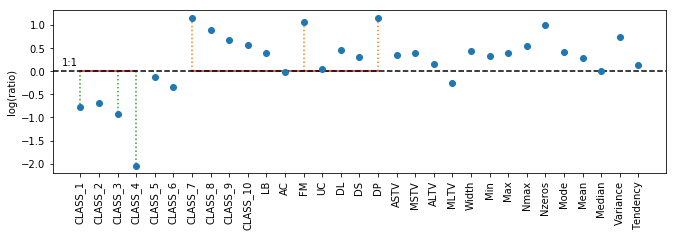

In [9]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = onehot_features
)

C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(num/denom)
C:\Dev\Study\python\interpret_basics\rf_analysis_utils.py:204: RuntimeWarning: invalid value encountered in true_divide
  yerr = 0.434*np.sqrt((num_err/num)**2 + (denom_err/denom)**2)


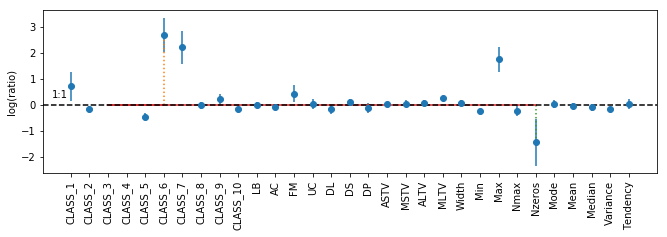

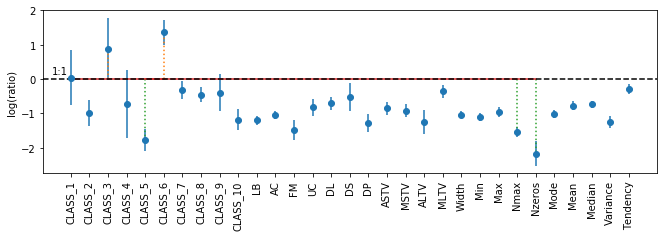

In [11]:
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_child_traversals'],
                           denom = tt_correct_stats[0]['m_child_traversals'],
                           num_err = tt_correct_stats[1]['sd_child_traversals'],
                           denom_err = tt_correct_stats[0]['sd_child_traversals'],
                           labels = onehot_features)

log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals'],
                           denom = tt_correct_stats[0]['m_lower_traversals'],
                           num_err = tt_correct_stats[1]['sd_lower_traversals'],
                           denom_err = tt_correct_stats[0]['sd_lower_traversals'],
                           labels = onehot_features)

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [ ]:
first_n = 14 # python is 'up to but not including'

batch = X_test[0:first_n]
labels = y_test[0:first_n]

preds = enc_model.predict(batch)

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

paths = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')

# there is a bug in sklearn causing all the warnings. This should be fixed in next release.
pretty_print_tree_votes(paths, preds, labels)

In [ ]:
# profiling a single instance
instance = 1

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

# Display instance row
germ_id = batch[instance:instance + 1].index[0]
german[germ_id:germ_id + 1]

In [ ]:
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='majority')
                                           , vars_dict, 4),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)
# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='minority')
                                               , vars_dict, 4),
                                 support = 0.1, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

In [ ]:
pretty_print(ra.rule, onehot_dict)

In [ ]:
ra.prune_rule()
pretty_print(ra.pruned_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
ra.pruned_rule

In [ ]:
p_count(training_labels.loc[apply_rule([
 ('crhis_A30', True, 0.5),
 ('crhis_A31', True, 0.5),
 ('job_A174', False, 0.5),
 ('tel_A192', False, 0.5),
 ('emp_A75', False, 0.5),
 #('pers_A93', False, 0.5),
 ('chk_A12', False, 0.5)
], encoder.transform(training_data), onehot_features)].values)

In [ ]:
ra4 = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)
for i in range(4):
    ra4.add_rule()
ra4.prune_rule()
pretty_print(ra4.pruned_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra4.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
pretty_print(ra_min.rule)

In [ ]:
ra_min.prune_rule()
pretty_print(ra_min.pruned_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
pretty_print(ra_min.tight_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.tight_rule, encoder.transform(training_data), onehot_features)].values)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()